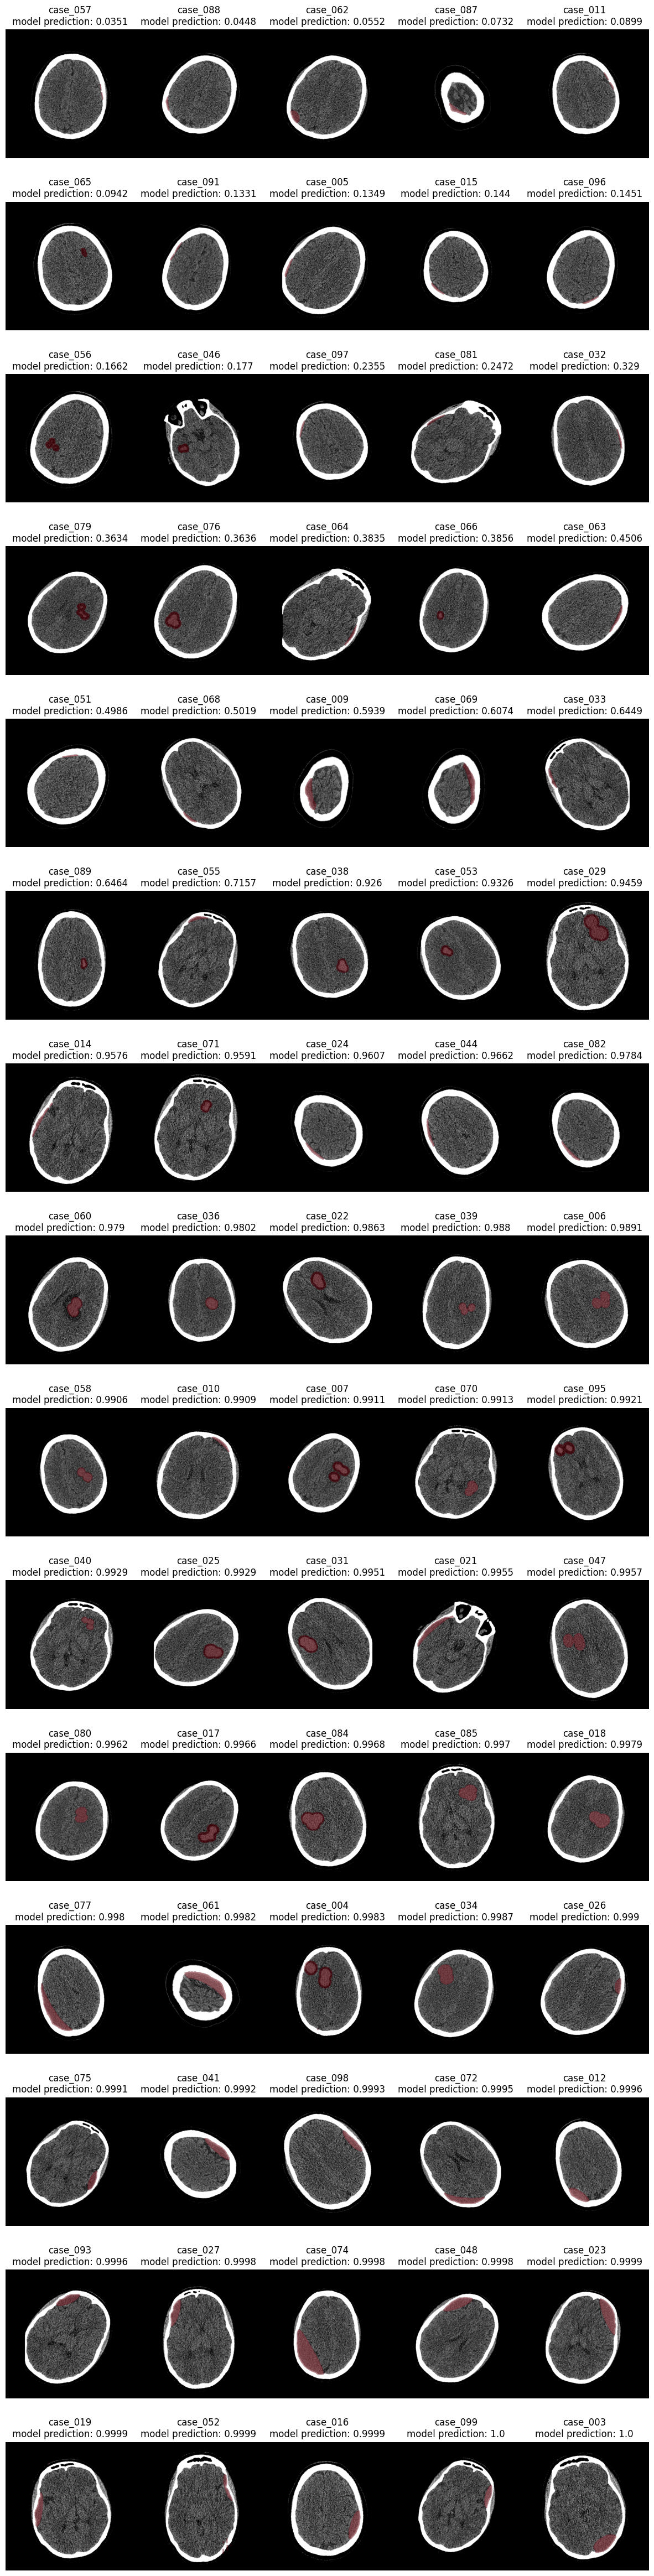

In [24]:
import sys
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pydicom

# options
mask_method = 'boundary' # 'boundary' or 'fill'

# paths
#dataset_path = '../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'
dataset_path = '/projects01/didsr-aiml/jayse.weaver/insilicoich/mA_280_run1/'
results_df = pd.read_csv('/projects01/didsr-aiml/jayse.weaver/insilicoich/mA_280_run1/mA_280_run1_results_v2.csv')
metadata_df = pd.read_csv('/projects01/didsr-aiml/jayse.weaver/insilicoich/mA_280_run1/mA_280_run1_metadata.csv')

# sort by Model_Output, ascending=True will give lowest predictive value first
results_df = results_df.sort_values(by='pred', ascending=True)

# just visualize the cases with hemorrhage (we're looking at the false negatives)
lesion_present_IDs = results_df[results_df['truth'] == 1]['case'].tolist()

def read_dicom(img_path):
    dcm = pydicom.read_file(img_path)
    return dcm.pixel_array + int(dcm.RescaleIntercept)

rows = 15
cols = 5
fig, axs = plt.subplots(nrows=rows, ncols=cols, gridspec_kw=dict(wspace=0, hspace=0.2), figsize=(3*cols, 4*rows))
axs = axs.flat
for ax, patient in zip(axs, lesion_present_IDs):
    model_pred = round(results_df[results_df['case'] == patient]['pred'].item(), 4)
    patient = str(patient).zfill(3)

    # find slice with biggest hemorrhage mask and load dicom
    case_metadata = metadata_df[metadata_df['name'] == patient]
    vol_max_idx = case_metadata['lesion volume [mL]'].idxmax()

    img_path = case_metadata['image file'][vol_max_idx]
    mask_path = case_metadata['mask file'][vol_max_idx]

    img = read_dicom(img_path)

    mask = read_dicom(mask_path)
    mask = np.where(mask > 0, 1, 0) # binarize mask

    alpha = 0.5
    cmap='Reds_r'

    # plot
    mask = ski.morphology.opening(mask, np.ones(2*[5]))
    new_mask = np.ma.masked_where(mask == False, mask)
    ax.imshow(img, vmin=0, vmax=120, cmap='gray') # show img
    ax.imshow(new_mask, cmap=cmap, alpha=alpha)

    ax.set_title(f'{patient}\nmodel prediction: {model_pred}')
    ax.axis('off')


<Axes: xlabel='volume', ylabel='pred'>

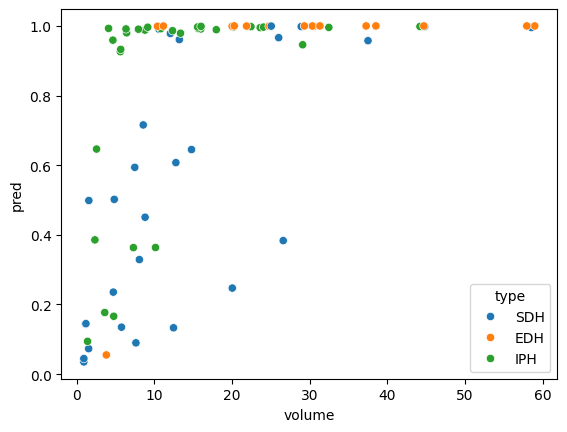

In [25]:
import seaborn as sns
sns.scatterplot(data=results_df, x='volume', y='pred', hue='type')

In [26]:
results_df.corr(numeric_only=True)

,Unnamed: 0,truth,pred,volume,intensity
Unnamed: 0,1.000000,0.046802,-0.131499,-0.236959,-0.073054
truth,0.046802,1.000000,0.647849,NaN,NaN
pred,-0.131499,0.647849,1.000000,0.540164,0.307929
volume,-0.236959,NaN,0.540164,1.000000,0.197348
intensity,-0.073054,NaN,0.307929,0.197348,1.000000


<Axes: xlabel='intensity', ylabel='pred'>

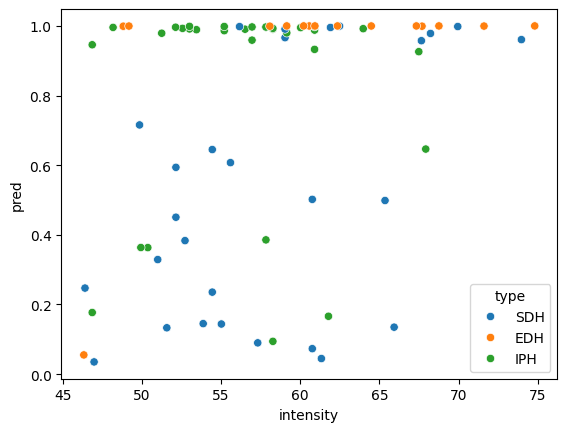

In [27]:
sns.scatterplot(data=results_df, x='intensity', y='pred', hue='type')